## Introducción

Este es un ejercicio de programación científica. Construiremos una simulación usando física muy básica usando técnicas y herramientas de programación modernas. Conforme lean el código van a encontrar notación y librerías que tal vez no conozcan. Dedíquenle tiempo a lo que no entiendan: internet está repleto de información gratuita que les va a contestar cualquier pregunta que les surja leyendo este documento. Lo que aprendan aquí les va servir en cualquier tipo de simulación numérica avanzada con la que se topen en sus carreras. Resolver un sistemas de ecuaciones diferencales parciales de forma numérica sigue una secuencia muy similar a la que verán aquí. Lo mismo para CFD o dinámica de fluídos. Si les gusta <i>simular cosas</i> con las computadora pues este material les debe resultar fácil. Si no es así, al menos ya saben en donde les duele. Yo trabajo haciendo simulaciones numéricas en la industria privada y este tipo de programas son cosa de todos los días. ¡Suerte!

La simulación consiste en una caja rectangular con partículas puntuales que se mueven a velocidad constante y colisionan con las paredes y diferentes obstáculos pero no entre ellas. Variaremos la cantidad de obstáculos e intentaremos verificar si existe alguna relación entre esa geometría y el número de partículas que cruzan un extremo de la caja o escapan por unidad de tiempo.

Para empezar escribamos una función de python que cree y devuelva un gráfico que represente la caja. Tendremos cuidado de que las dimensiones de este gráfico coincidan con las de la simulación de modo que podamos verificar visualmente si nuestras ecuaciones tienen sentido.

La caja tiene dimensiones $L \times h$ y sus bordes un ancho $l_w$. Note el uso de este ancho para definir donde <i>dibujamos</i> los bordes de la caja.

Revisar: <a href="https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.patches.Rectangle.html">matplotlib Rectangle patch</a>

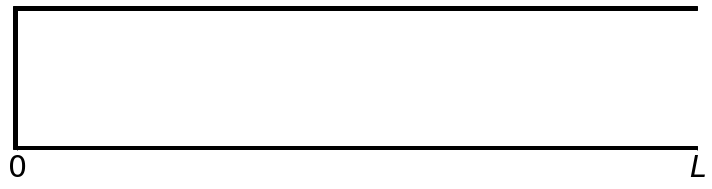

In [1]:
import numpy as np
import matplotlib.pyplot as plt

L = 5
h = 1
lw = 0.025

def create_base_plot():
    fig,ax1 = plt.subplots(1,1,figsize=(10,3))
    ax1.set_aspect('equal')
    ax1.add_patch(plt.Rectangle((0, -lw), L, lw, fill=True, facecolor='black', edgecolor='black', clip_on=False))
    ax1.add_patch(plt.Rectangle((0, h), L, lw, fill=True, facecolor='black', edgecolor='black', clip_on=False))
    ax1.add_patch(plt.Rectangle((-lw, -lw), lw, h+2*lw, fill=True, facecolor='black', edgecolor='black', clip_on=False))
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_xticks([0, L])
    ax1.set_xticklabels(['$0$', '$L$'], fontsize=30)

    plt.tight_layout()
    return fig, ax1

fig, ax1 = create_base_plot()
plt.show()

## Partículas

Ahora agreguemos algunas partículas a la caja pero antes algunas precisiones:
* Que las partículas comiencen del lado izquierdo de la caja con velocidad y posición iniciales aleatorias
* También definimos una velocidad máxima $\frac{L}{50}$
* <i>numpy.random.random()</i> devuelve un número racional entre $0$ y $1$ tomado de la distribución uniforme

<IPython.core.display.Javascript object>


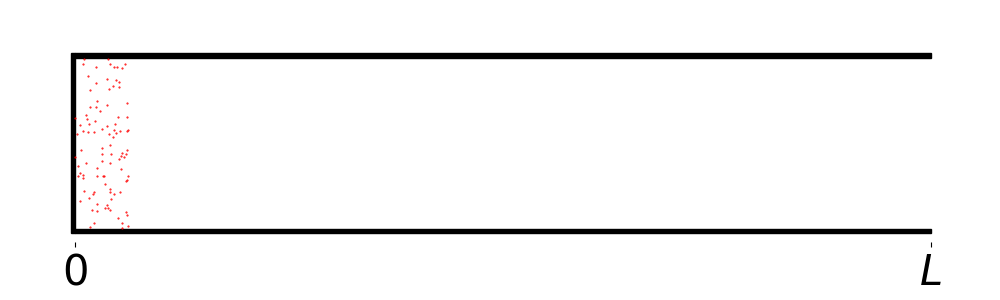

In [7]:
N = 100 # Number of particles
particles = []

def create_simple_particle(ax=None):
    x = np.random.random()*L/16
    y = np.random.random()*h   
    vx = np.random.random()*L/50 * (1 if np.random.random() < 0.5 else -1)
    vy = np.random.random()*L/50 * (1 if np.random.random() < 0.5 else -1)
    return {
        'x'      : x,
        'y'      : y,
        'vx'     : vx,
        'vy'     : vy,
        'marker' : (ax.plot(x, y, 'r.', markersize=1)[0]
                    if ax != None 
                    else None)
    }

fig, ax1 = create_base_plot()
for n in range(N):
    particles.append(create_simple_particle(ax1))

plt.show()

Compliquemos las cosas un poco más agregando el primer poquito de física al asunto. Las partículas se mueven según las reglas del movimiento rectilíneo uniforme. Antes de introducir colisiones y obstáculos también agreguemos la <i>confirmación visual</i> que mencionamos antes. La función <i>matplotlib.animation.FuncAnimation</i> toma como parámetro una función a la que llama cada vez que va a construir un nuevo cuadro de la animación. Es en esta función donde nostros inyectamos código que actualice las posiciones de las partículas. Observen como solo se avanza el reloj por $dt$ cada cuadro de la animación. Esperamos ver que todas las partículas vuelen fuera de la caja sin chocar.

Revisar <a href="https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.animation.FuncAnimation.html">matplotlib.animation.FuncAnimation</a>

<IPython.core.display.Javascript object>


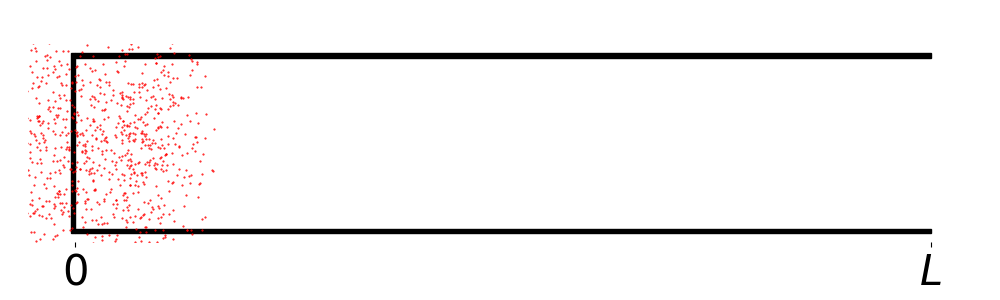

In [8]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

N = 1000
dt = 0.05

fig, ax1 = create_base_plot()
particles = []
for n in range(N):
    particles.append(create_simple_particle(ax1))

def update(frame):
    for p in particles:
        p['x'] = p['x'] + p['vx']*dt
        p['y'] = p['y'] + p['vy']*dt
        p['marker'].set_data(p['x'], p['y'])
        
    return map(lambda p: p['marker'], particles)

animation = FuncAnimation(fig, update, 
                          frames=100, 
                          blit=True, 
                          interval=1/60, 
                          repeat=False)
plt.show()


## Obstáculos

Queremos agregar obstáculos con los que las partículas van a chocar. Si pensamos en un fluído dentro de un tubo, estos obstáculos son bloqueos que afectan las condiciones de flujo observadas en la salida del tubo. Para mantener la atención en la programación y no tanto en las matemáticas, escojamos obstáculos cuadrados espaciados de manera simétrica o regular por toda la caja. Escribiremos dos métodos nuevos:
* <i>add_obstacles</i>: toma unos ejes de matplotlib, un número de filas y columnas y devuelve una lista de cuadrados de lado $l_w$ y las coordenadas de su centro. Esta lista se usará en la función que actualiza las posiciones para determinar si una partícula está chocando contra algún obstáculo.
* <i>is_particle_on_obstacle</i>: función que verifica si una partícula está o no sobre un obstáculo. Cuando generamos posiciones aleatorias no sabemos de antemano si esas coordenadas violan la geometría que definimos

<IPython.core.display.Javascript object>


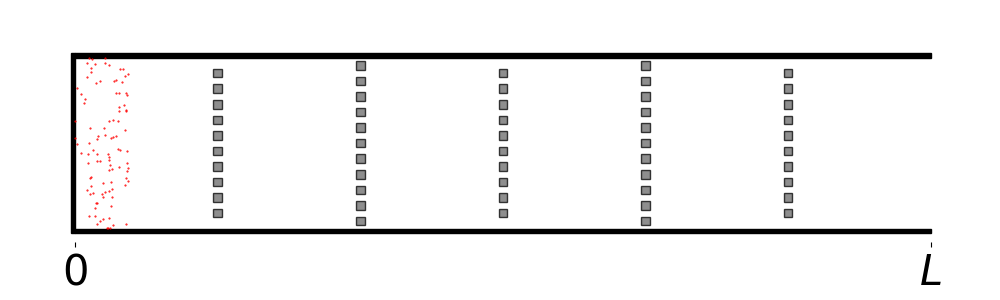

In [9]:
%matplotlib notebook
from matplotlib.patches import Rectangle

N = 100
l = 0.05
rows = 10
cols = 5
base_speed = L/50

def add_obstacles(ax=None, n_rows=1, n_cols=1):
    obstacles = []
    col_domain = np.linspace(0, L, n_cols+2)
    row_domain, dr = np.linspace(0, h, n_rows+2, retstep=True)
    for k1,i in enumerate(col_domain):
        for k2,j in enumerate(row_domain):
            is_even_col = (k1 % 2 == 0)
            x = i
            y = j + (dr/2 if is_even_col else 0)
            if 0 < x < L and 0 < y < h:
                obstacles.append({
                        'x' : x,
                        'y' : y,
                })
                if ax != None:
                    ax.add_patch(plt.Rectangle((x - l/2, y - l/2), l, l,
                                            facecolor='dimgrey',
                                            edgecolor='black',
                                            alpha=0.75,
                                            fill=True,
                                            clip_on=False))
    return obstacles

def is_particle_on_obstacle(x,y):        
    if (h - y) < 0: # Top wall
        return True
    if y < 0: # Bottom wall
        return True
    if x < 0: # Left wall
        return True

    for w in obstacles:
        is_inside_x = (w['x'] - l/2) < x < (w['x'] + l/2)
        is_inside_y = (w['y'] - l/2) < y < (w['y'] + l/2)
        if is_inside_x and is_inside_y:
            return True
    return False

def create_particle(ax=None, obstacles=[]):
    x = np.random.random()*L/16
    y = np.random.random()*h    

    attempts = 0
    while is_particle_on_obstacle(x,y):
        x = np.random.random()*L/16
        y = np.random.random()*h        
        attempts += 1
        assert attempts < 1000, 'Something went wrong, review is_particle_on_obstacle'
    
    vx = np.random.random()*base_speed * (1 if np.random.random() < 0.5 else -1)
    vy = np.random.random()*base_speed * (1 if np.random.random() < 0.5 else -1)
    
    return {
        'x'      : x,
        'y'      : y,
        'vx'     : vx,
        'vy'     : vy,
        'marker' : (ax.plot(x, y, 'r.', markersize=1)[0]
                    if ax != None 
                    else None)
    }

fig, ax1 = create_base_plot()
obstacles = add_obstacles(ax1, rows, cols)
particles = []
for n in range(N):
    particles.append(create_particle(ax1, obstacles))
    
plt.show()

<IPython.core.display.Javascript object>


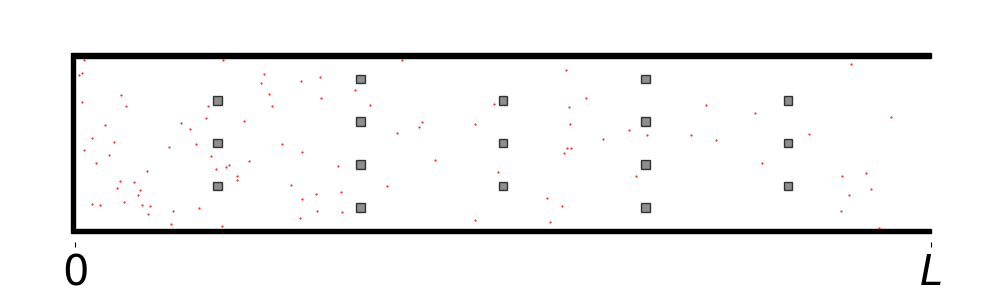

In [10]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

N = 100
dt = 0.05
rows = 3
cols = 5
total_frames = 1000

def reset_particle(p):
    """ Return particle to a start-like position and velocity """
    x = np.random.random()*L/16
    y = np.random.random()*h
    attempts = 0
    while is_particle_on_obstacle(x,y):
        x = np.random.random()*L/16
        y = np.random.random()*h        
        attempts += 1
        assert attempts < 1000, 'Something went wrong, review is_particle_on_obstacle'        
    p['x'] = x
    p['y'] = y    
    p['vx'] = np.random.random()*base_speed * (1 if np.random.random() < 0.5 else -1)
    p['vy'] = np.random.random()*base_speed * (1 if np.random.random() < 0.5 else -1)

def update_velocity_and_position(p,residual):
    # Sometimes particles hit a corner head-on
    if is_particle_on_obstacle(p['x'], p['y']):
        reset_particle(p)
        return
    
    # Parametrize trajectory
    x0 = p['x']
    xf = p['x'] + p['vx']*residual    
    y0 = p['y']
    yf = p['y'] + p['vy']*residual
    
    # Top wall
    if (yf - y0) != 0:
        tc = residual*(h - y0)/(yf - y0)
        if 0 < tc <= residual:
            residual -= tc
            p['x'] = p['x'] + p['vx']*tc
            p['y'] = h
            p['vy'] = -p['vy']
            if not np.isclose(0, residual):
                update_velocity_and_position(p, residual)
            else:
                return

    # Bottom wall
    if (yf - y0) != 0:
        tc = residual*(-y0)/(yf - y0)
        if 0 < tc <= residual:
            residual -= tc
            p['x'] = p['x'] + p['vx']*tc
            p['y'] = 0
            p['vy'] = -p['vy']
            if not np.isclose(0, residual):
                update_velocity_and_position(p, residual)
            else:
                return
    
    # Left wall
    if (xf - x0) != 0:
        tc = residual*(-x0)/(xf - x0)
        if 0 < tc <= residual:
            residual -= tc
            p['x'] = 0
            p['y'] = p['y'] + p['vy']*tc        
            p['vx'] = -p['vx']
            if not np.isclose(0, residual):
                update_velocity_and_position(p, residual)
            else:
                return

    for w in obstacles:
        # Left wall
        if (xf - x0) != 0:
            tc = residual*(w['x'] - l/2 - x0)/(xf - x0)
            __yf = p['y'] + p['vy']*tc
            if (0 < tc <= residual) and ((w['y'] + l/2) > __yf > (w['y'] - l/2)):
                residual -= tc
                p['x'] = w['x'] - l/2
                p['y'] = p['y'] + p['vy']*tc
                p['vx'] = -p['vx']
                if not np.isclose(0, residual):
                    update_velocity_and_position(p, residual)
                else:
                    return

        # Right wall
        if (xf - x0) != 0:
            tc = residual*(w['x'] + l/2 - x0)/(xf - x0)
            __yf = p['y'] + p['vy']*tc
            if 0 < tc <= residual and ((w['y'] + l/2) > __yf > (w['y'] - l/2)):
                residual -= tc
                p['x'] = w['x'] + l/2 
                p['y'] = p['y'] + p['vy']*tc
                p['vx'] = -p['vx']
                if not np.isclose(0, residual):
                    update_velocity_and_position(p, residual)
                else:
                    return

        # Top wall
        if (yf - y0) != 0:
            tc = residual*(w['y'] + l/2 - y0)/(yf - y0)
            __xf = p['x'] + p['vx']*tc
            if 0 < tc <= residual and ((w['x'] - l/2) < __xf < (w['x'] + l/2)):
                residual -= tc
                p['x'] = p['x'] + p['vx']*tc
                p['y'] = w['y'] + l/2
                p['vy'] = -p['vy']
                if not np.isclose(0, residual):
                    update_velocity_and_position(p, residual)
                else:
                    return

        # Bottom wall
        if (yf - y0) != 0:
            tc = residual*(w['y'] - l/2 - y0)/(yf - y0)
            __xf = p['x'] + p['vx']*tc
            if 0 < tc <= residual and ((w['x'] - l/2) < __xf < (w['x'] + l/2)):
                residual -= tc
                p['x'] = p['x'] + p['vx']*tc
                p['y'] = w['y'] - l/2
                p['vy'] = -p['vy']
                if not np.isclose(0, residual):
                    update_velocity_and_position(p, residual)
                else:
                    return
                
    if not np.isclose(0, residual):
        p['x'] = p['x'] + p['vx']*residual
        p['y'] = p['y'] + p['vy']*residual
        residual = 0

def update(frame): 
    global counter
    for p in particles:
        update_velocity_and_position(p, dt)
        if p['x'] > L:
            reset_particle(p)
        p['marker'].set_data(p['x'], p['y'])        
    return map(lambda p: p['marker'], particles)

fig, ax1 = create_base_plot()
obstacles = add_obstacles(ax1, rows, cols)
particles = []
for n in range(N):
    particles.append(create_particle(ax1, obstacles))

animation = FuncAnimation(fig, update, 
                          frames=total_frames, 
                          blit=True, 
                          interval=1,
                          repeat=False)

plt.show()

<IPython.core.display.Javascript object>


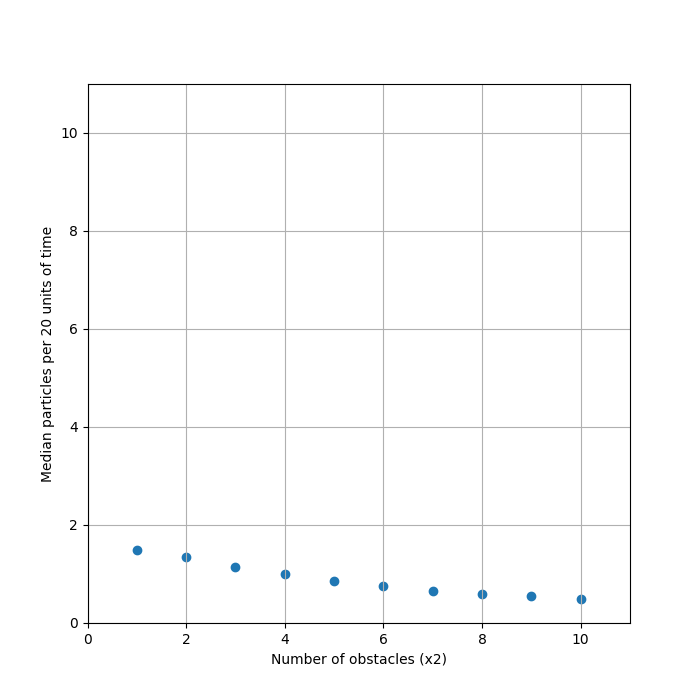

In [12]:
# assert False, "Agrega un # al inicio de esta línea para ejecutar este bloque. Paciencia. Tomará un par de horas."

import pandas as pd
from time import time

N = 500
dt = 1
many_rows = list(range(1, 10+1))
cols = 2

total_frames = 10000
sample_every_n = 20

# med = []
# sdev = []
# for _r in many_rows:
#     # Create particles and obstacles
#     obstacles = add_obstacles(n_rows=_r, n_cols=cols)
#     particles = []
#     q = []
#     counter = 0
#     clock = 0
    
#     for n in range(N):
#         particles.append(create_particle(obstacles=obstacles))
        
#     # Run entire simulation
#     for n in range(total_frames):
#         for p in particles:
#             update_velocity_and_position(p, dt)
#             if p['x'] > L:
#                 counter += 1
#                 reset_particle(p)
                
#         # Update clock
#         clock += dt
#         if clock >= sample_every_n:
#             q.append(counter)
#             clock = 0
#             counter = 0        

#         print(f'>> Frame {n+1} of {total_frames}         ', end='\r')            
    
#     print('')
#     # Record median and std dev around this value
#     m = np.median(q)/sample_every_n
#     med.append(m)
#     sdev.append(np.sqrt(np.sum((np.array(q)/sample_every_n - m)**2)/len(q)))

# pd.to_pickle((many_rows, cols, med, sdev), f'./results_{cols}_cols.dat')
# Guardar tus datos antes de graficar te puede facilitar la tarea de crear y pulir
# las graficas, además de hacer una copia de seguridad de tus datos que tomaron horas
# en ser generados!
(many_rows, cols, med, sdev) = pd.read_pickle(f'./results_{cols}_cols.dat')

fig, ax1 = plt.subplots(1, 1, figsize=(7,7))

ax1.scatter(many_rows, med)

ax1.set_ylabel(f'Median particles per {sample_every_n} units of time')
ax1.set_xlabel(f'Number of obstacles (x{cols})')
ax1.set_xlim([0, len(many_rows)+1])
ax1.set_ylim([0, len(many_rows)+1])

ax1.grid()